### Gather articles for AOM Annals Paper using the scopus api wrapper

Using https://scopus.readthedocs.io/en/latest/examples/ScopusAbstract.html

In [86]:
import pandas as pd
from scopus import ScopusAbstract
from scopus import ScopusSearch
import pickle
import numpy
import re

In [257]:
import os
import os.path
from os import listdir
from os.path import isfile, join, expanduser
import shutil

In [6]:
from textblob import TextBlob 
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

### Setup

In [7]:
std_date_format = '%Y-%m-%d'    
home_path = expanduser("~")

### Main Code

In [8]:
fetchFlag = True # fetchFlag determines whether I hit the Scopus server

Query is looking at abstracts and titles from "Social Sciences" and "Business, Management and Accounting" after 2007 for "topic modeling"

TITLE-ABS-KEY("topic modeling") AND PUBYEAR > 2007 AND ( LIMIT-TO ( SUBJAREA,"SOCI" ) OR LIMIT-TO ( SUBJAREA,"BUSI" ) ) 

Using the scopus search webUI, there should be 654 document results(213 document results business only); note, the ScopusSearch API does not include LIMIT-TO, so for subjects, need to use SUBJAREA("BUSI")  https://dev.elsevier.com/tips/ScopusSearchTips.htm

In [33]:
query = ScopusSearch('TITLE-ABS-KEY("topic modeling") AND PUBYEAR > 2007 AND (SUBJAREA("BUSI") or SUBJAREA("SOCI")) ', refresh=True)

In [34]:
len(query.EIDS)

654

In [35]:
results = []
i=0
for eid in query.EIDS:
    if fetchFlag: ab = ScopusAbstract(eid, view='FULL')
    if i % 5 == 0: print (i) # print processing progress, every 5
    i+=1
    if fetchFlag: results.append(ab)
    #ab.references # list of eIDS, useful to build citation networks

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650


In [37]:
len(results)

654

In [38]:
with open('all_abstracts_forOct2_query.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load pickle (note: likely need to be connected to University VPN to use this)

In [39]:
with open('all_abstracts_forOct2_query.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [40]:
results[0]

##### To find list of all publication names, use this code
for ab in results:
    print(ab.publicationName)

Using list, can filter for specific journals

In [36]:
journalsToUse = [] # use the lower case name of journals to filter

In [10]:
results_filtered = []
for ab in results:
    for journalName in journalsToUse:
        if ab.publicationName.lower() == journalName.lower():
            results_filtered.append(ab)

Because scopus.scopus_api.ScopusAbstract requires University VPN, need to save dataframe on iMac

In [42]:
results_filtered = results # no filtering at this time
ab_for_df = []
for ab in results_filtered:
    ab_dict = {"publicationName": ab.publicationName, "date": ab.coverDate, "title": ab.title, "abstract":ab.abstract, "id":ab.eid}
    # authors?
    ab_for_df.append(ab_dict)   

In [43]:
df_ab = pd.DataFrame(ab_for_df)
df_ab.to_csv("df_abstracts.csv")

_Example:_

ab.publicationName
'ACS Catalysis'
ab.aggregationType
'Journal'
ab.coverDate
'2015-06-05'
ab.volume
'5'
ab.issueIdentifier
'6'
ab.pageRange
'3894-3899'
ab.doi
'10.1021/acscatal.5b00538'

In [ ]:
#with open('all_abstracts_ETP_JBV_post2008.pickle', 'wb') as handle:
#    pickle.dump(results_filtered, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load csv for all paper abstracts

In [197]:
df_ab = pd.read_csv("df_abstracts.csv")

In [198]:
len(df_ab)

654

##### capture journal names, put into a counter

In [199]:
import collections
from collections import defaultdict
journal_count = defaultdict(int)

In [200]:
for i, row in df_ab.iterrows():    
    journal_count[row['publicationName']]+=1

In [201]:
df_journal_count = pd.DataFrame.from_dict(journal_count, orient="index")

In [202]:
df_journal_count = df_journal_count.sort_values(0, ascending=False)

In [203]:
df_journal_count.columns=["articleCounts"]

In [204]:
df_journal_count.head(2)

,articleCounts
"International Conference on Information and Knowledge Management, Proceedings",61
Knowledge-Based Systems,31


In [205]:
df_journal_count.to_csv("df_journal_count.csv")

### Preprocessing abstracts

In [206]:
# some abstracts are NaN; filter these out
df_ab['abstract'] = df_ab['abstract'].fillna("-")

Need to get rid of Copyright tags in footers such as: _© 2012 Elsevier B.V. All rights reserved._
Strategy: look for regex that matchines between © 20 and .

Examples: "© 2014 Copyright Taylor and Francis Group, LLC."; "Copyright is held by the owner/author(s).", "Copyright 2013 ACM."
-therefore, not all footers have copyright symbol, but they do have the word capitalized


In [207]:
symbol_pattern = "©(.*)"
word_pattern = "Copyright(.*)"
df_ab["abstract_cleaned"] = "" # prep column

for i, row in df_ab.iterrows():    
    if len(row["abstract"])>1:
        if "Copyright" in row["abstract"]:         
            abstract_cleaned = re.sub(word_pattern, "", row["abstract"])
        elif "©" in row["abstract"]:
            abstract_cleaned = re.sub(symbol_pattern, "", row["abstract"])
        else:
            abstract_cleaned = row["abstract"]
    df_ab.loc[i,"abstract_cleaned"]= abstract_cleaned.replace("All rights reserved", "")

In [208]:
df_ab = df_ab.drop(columns=["Unnamed: 0"])

In [209]:
df_ab.head(5)

,abstract,date,id,publicationName,title,abstract_cleaned
0,"Well-being as an intangible, philosophical, an...",2018-12-01,2-s2.0-85048543703,Tourism Management,Hedonic and eudaimonic well-being: A psycholin...,"Well-being as an intangible, philosophical, an..."
1,The rapid growth of the Chinese economy has re...,2018-11-20,2-s2.0-85053080182,Journal of Cleaner Production,Heterogeneity evaluation of China's provincial...,The rapid growth of the Chinese economy has re...
2,The aim of this study is to introduce a decisi...,2018-11-10,2-s2.0-85007493460,Total Quality Management and Business Excellence,Topic modelling-based decision framework for a...,The aim of this study is to introduce a decisi...
3,The new reality of networked publics on social...,2018-11-01,2-s2.0-85050884991,Public Relations Review,Examining multiplicity and dynamics of publics...,The new reality of networked publics on social...
4,Topic models often produce unexplainable topic...,2018-11-01,2-s2.0-85048519194,Information Processing and Management,Exploring coherent topics by topic modeling wi...,Topic models often produce unexplainable topic...


How many rows have NaN abstracts?

In [210]:
df_ab.count()

abstract            654
date                654
id                  654
publicationName     654
title               654
abstract_cleaned    654
dtype: int64

In [211]:
rowsWithNoAbstracts = []
for i, row in df_ab.iterrows():    
    if len(row["abstract"])<2: rowsWithNoAbstracts.append(i)
print(rowsWithNoAbstracts)

[99, 209, 351, 606]


Therefore need to remove these

In [212]:
df_ab = df_ab.drop(rowsWithNoAbstracts)

In [213]:
df_ab.count()

abstract            650
date                650
id                  650
publicationName     650
title               650
abstract_cleaned    650
dtype: int64

In [214]:
df_ab['publicationName'].nunique()

307

Now, save this file as csv (will be used in processing LDA output)

In [215]:
df_ab.to_csv("article_list_cleaned.csv")

Now ready to pre-process abstract column

In [216]:
abstracts_all = df_ab['abstract_cleaned']

### now, pre-process the text for LDA topic modeling

In [217]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /Users/Tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Preprocessing methods

In [218]:
en_stopwords_path = home_path+'/nltk_data/corpora/stopwords/english'
en_stopwords = [line.rstrip('\n') for line in open(en_stopwords_path)]

In [219]:
def removeStopWordsAndSingularizePhrase(phrase): # remove personal pronouns , articles, prepositions; this helps clean phrases for comparison
    #phrase = unidecode(phrase) # for simplicity, only working in ASCII, need to look for a pythonic way of doing this that is not dependent on a package    
    #phrase = phrase.replace("-", " ") # replace dashes with periods
    phrase = phrase.replace("'s", "") 
    phrase = phrase.replace(",", "")     
    phrase_tb = TextBlob(phrase)
    #stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer() # more here: http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
    phrase_clean = ""
    for word in phrase_tb.words:
        if len(word)>1: # this may be controversial
            regex_pattern = re.compile(r'\b%s\b'%word, re.I)  
            #if word not in en_stopwords+["the", "a"]: # this will not match case insensitivity 
            wordInStopWordsFlag = False # default
            for stopword in en_stopwords+["the", "a"]: # this is a more robust alternative approach
                if regex_pattern.search(stopword): # note: this is the wide matching condition, contrast this to equality matching                                                    
                    wordInStopWordsFlag = True
                    break
            if wordInStopWordsFlag==False:
                word_replacement = wordnet_lemmatizer.lemmatize(word)
                #if word_replacement != word:                 
                #    word_replacement = word_replacement+"*" # this indicates a phrase has been stemmed
                #    #print "word_replacement:", word_replacement
                phrase_clean=phrase_clean+word_replacement+" "  
    return phrase_clean.strip()



In [220]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text)#, pos='v')

In [221]:
def preprocess(text):
    result = []
    text_cleaned = text
    text_cleaned = re.sub("All rights reserved\.","",text_cleaned, flags=re.IGNORECASE)    
    for sent in sent_tokenize(text_cleaned):
        #print (sent)
        for word in word_tokenize(sent):            
            #print (word)
            word_cleaned = removeStopWordsAndSingularizePhrase(word).lower()            
            if word_cleaned not in en_stopwords and len(word_cleaned) > 3:
                #print (word_cleaned)
                result.append(word_cleaned)
    #        result.append(lemmatize_stemming(token))
    #for token in gensim.utils.simple_preprocess(text_cleaned):
    #    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
    #        result.append(lemmatize_stemming(token))
    return result

#### Sample document

In [225]:
# sample doc
abstracts_all[0]

"Well-being as an intangible, philosophical, and multi-faceted phenomenon is hard to measure. By taking a psycholinguistic expression of well-being, we measure how tourists' experiencing holiday destinations affects their well-being states. The well-being state includes increases or decreases in Hedonia and Eudaimonia as a result of destination experiences. We apply text topic modelling to analyse big Web 2.0 datasets. These include tourists’ self-reports of their experiences during their visit to destination countries collected from Travelblog.org weblog. The findings from a Global sample, New Zealand, and France are compared to generalise Hedonia and Eudaimonia conceptualisations across these destinations. The outputs also characterise experiences with maximum well-being and ill-being that include both Hedonia and Eudaimonia. Managerial implications include how a destination image may be managed according to desired well-being states. This also helps tourists make informed decisions 

In [224]:
# sample doc
print(preprocess(abstracts_all[0]))

['well-being', 'intangible', 'philosophical', 'multi-faceted', 'phenomenon', 'hard', 'measure', 'taking', 'psycholinguistic', 'expression', 'well-being', 'measure', 'tourist', 'experiencing', 'holiday', 'destination', 'affect', 'well-being', 'state', 'well-being', 'state', 'includes', 'increase', 'decrease', 'hedonia', 'eudaimonia', 'result', 'destination', 'experience', 'apply', 'text', 'topic', 'modelling', 'analyse', 'datasets', 'include', 'tourist', 'self-reports', 'experience', 'visit', 'destination', 'country', 'collected', 'travelblog.org', 'weblog', 'finding', 'global', 'sample', 'zealand', 'france', 'compared', 'generalise', 'hedonia', 'eudaimonia', 'conceptualisation', 'across', 'destination', 'output', 'also', 'characterise', 'experience', 'maximum', 'well-being', 'ill-being', 'include', 'hedonia', 'eudaimonia', 'managerial', 'implication', 'include', 'destination', 'image', 'managed', 'according', 'desired', 'well-being', 'state', 'also', 'help', 'tourist', 'make', 'informe

Now, clean all documents

In [226]:
# all docs
processed_docs = [preprocess(abstract) for abstract in abstracts_all]

In [227]:
processed_docs_as_string = [' '.join(doc) for doc in processed_docs ]

#### should we pre-process phrases?

This could be informed by trigram and bigram analysis

In [228]:
import nltk
from nltk.util import ngrams
import collections
from collections import Counter
bigrams_counter = collections.Counter()
trigrams_counter = collections.Counter()

In [233]:
for abstract_processed in processed_docs:
    bigrams = ngrams(abstract_processed,2)
    trigrams = ngrams(abstract_processed,3)
    bigrams_counter.update(bigrams)
    trigrams_counter.update(trigrams)

In [234]:
print ('Most common trigrams:')
for letter, count in trigrams_counter.most_common(50):
    print ('%s: %7d' % (letter, count))

Most common trigrams:
('latent', 'dirichlet', 'allocation'):     262
('experimental', 'result', 'show'):      56
('natural', 'language', 'processing'):      48
('probabilistic', 'topic', 'modeling'):      46
('topic', 'modeling', 'approach'):      46
('topic', 'modeling', 'technique'):      44
('analysis', 'topic', 'modeling'):      42
('using', 'topic', 'modeling'):      40
('online', 'social', 'network'):      40
('probabilistic', 'topic', 'model'):      40
('social', 'medium', 'data'):      38
('dirichlet', 'allocation', 'model'):      34
('dirichlet', 'allocation', 'topic'):      28
('latent', 'semantic', 'analysis'):      26
('proceeding', 'contain', 'paper'):      26
('topic', 'modeling', 'method'):      24
('online', 'product', 'review'):      24
('paper', 'propose', 'novel'):      22
('topic', 'modeling', 'algorithm'):      22
('probabilistic', 'latent', 'semantic'):      22
('sentiment', 'analysis', 'topic'):      20
('social', 'network', 'analysis'):      20
('based', 'latent

In [235]:
print ('Most common bigrams:')
for letter, count in bigrams_counter.most_common(30):
    print ('%s: %7d' % (letter, count))

Most common bigrams:
('topic', 'modeling'):     868
('topic', 'model'):     686
('social', 'medium'):     314
('latent', 'dirichlet'):     270
('dirichlet', 'allocation'):     266
('social', 'network'):     190
('result', 'show'):     154
('experimental', 'result'):     146
('topic', 'modelling'):     128
('text', 'mining'):     120
('short', 'text'):     118
('paper', 'propose'):     118
('latent', 'topic'):     116
('machine', 'learning'):     108
('sentiment', 'analysis'):      96
('probabilistic', 'topic'):      92
('paper', 'present'):      84
('proposed', 'method'):      78
('natural', 'language'):      76
('research', 'topic'):      72
('text', 'analysis'):      72
('public', 'opinion'):      66
('proposed', 'model'):      66
('number', 'topic'):      64
('using', 'topic'):      62
('case', 'study'):      62
('information', 'system'):      62
('climate', 'change'):      60
('information', 'retrieval'):      58
('text', 'data'):      56


In [236]:
import matplotlib as plt

In [237]:
bigrams_counter_dict =  dict(bigrams_counter)

In [238]:
bigrams_counter_df = pd.DataFrame.from_dict(bigrams_counter_dict, orient='index')

In [239]:
bigrams_counter_df = bigrams_counter_df.sort_values(by=[0],ascending=False
                                                     )

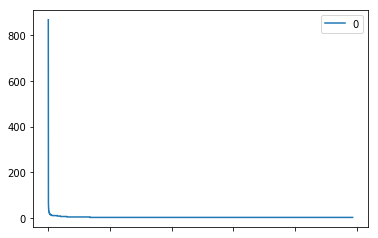

In [240]:
bigrams_counter_df.plot()

In [241]:
bigrams_counter_df.head(25)

,0
"(topic, modeling)",868
"(topic, model)",686
"(social, medium)",314
"(latent, dirichlet)",270
"(dirichlet, allocation)",266
"(social, network)",190
"(result, show)",154
"(experimental, result)",146
"(topic, modelling)",128
"(text, mining)",120


In [242]:
trigrams_counter_dict =  dict(trigrams_counter)

In [243]:
trigrams_counter_df = pd.DataFrame.from_dict(trigrams_counter_dict, orient='index')

In [244]:
trigrams_counter_df = trigrams_counter_df.sort_values(by=[0],ascending=False
                                                     )

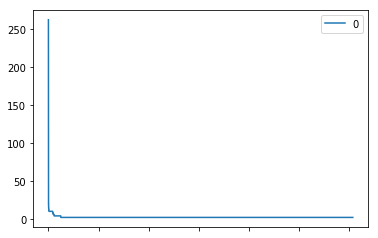

In [245]:
trigrams_counter_df.plot()

In [246]:
trigrams_counter_df.head(30)

,0
"(latent, dirichlet, allocation)",262
"(experimental, result, show)",56
"(natural, language, processing)",48
"(topic, modeling, approach)",46
"(probabilistic, topic, modeling)",46
"(topic, modeling, technique)",44
"(analysis, topic, modeling)",42
"(using, topic, modeling)",40
"(probabilistic, topic, model)",40
"(online, social, network)",40


# collapse phrases; to collapse phrases, include in this list, then run the code
phrases_to_collapse = [ ]

processed_docs_r = []  
for doc in processed_docs_as_string:
    for phrase in phrases_to_collapse:
        phrase_with_underscore = phrase.replace(" ", "_")
        doc = doc.replace(phrase, phrase_with_underscore)
    processed_docs_r.append(doc.split(" "))

### LDA methods

In [248]:
# work with Mallet wrapper in Gensim
from gensim.models.wrappers import LdaMallet
path_to_mallet_binary = home_path+"/Dev_stuff/mallet-2.0.8/bin/mallet"

In [273]:
# Filter out tokens that appear in: i) less than 15 documents (absolute number) or ii) more than 0.5 documents (fraction of total corpus size, not absolute number).
#dictionary = dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [249]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)

In [250]:
# Gensim doc2bow
# For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Now, actually doing the LDA

In [251]:
def generateModelCoherence(corpus, dictionary,processed_docs,step=5, start=5, end=10):
    # output a pandas dataframe with each row as a model; num_topics, coherence, model    
    i = 0
    num_topics = (i * step)+start
    models = []
    while num_topics<end:
        num_topics = i * step+start
        print ("num_topics:", num_topics)
        lda_model_mallet = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        cm = CoherenceModel(model=lda_model_mallet ,texts=processed_docs, corpus=corpus,dictionary=dictionary, coherence='c_v')
        print ("coherence:",cm.get_coherence())
        model_specs = {"num_topics":num_topics, "model":lda_model_mallet, "coherence":cm.get_coherence()}
        models.append(model_specs)
        i+=1 # increment step
    return pd.DataFrame(models)

In [252]:
all_models = generateModelCoherence(corpus, dictionary,processed_docs,5,10,100)

num_topics: 10
coherence: 0.41317160934189767
num_topics: 15
coherence: 0.395412320187844
num_topics: 20
coherence: 0.37597337199399283
num_topics: 25
coherence: 0.3752752299445272
num_topics: 30
coherence: 0.35728426914426287
num_topics: 35
coherence: 0.34683122305824365
num_topics: 40
coherence: 0.3578268557624157
num_topics: 45
coherence: 0.3587680163721683
num_topics: 50
coherence: 0.3387609794241579
num_topics: 55
coherence: 0.34466912446190223
num_topics: 60
coherence: 0.3445502426941443


In [253]:
all_models = all_models.set_index('num_topics')

In [254]:
all_models.head()

,coherence,model
num_topics,,
10,0.413172,<gensim.models.wrappers.ldamallet.LdaMallet ob...
15,0.395412,<gensim.models.wrappers.ldamallet.LdaMallet ob...
20,0.375973,<gensim.models.wrappers.ldamallet.LdaMallet ob...
25,0.375275,<gensim.models.wrappers.ldamallet.LdaMallet ob...
30,0.357284,<gensim.models.wrappers.ldamallet.LdaMallet ob...


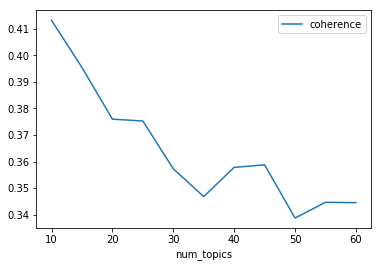

In [255]:
models_to_plot = all_models.copy() 
models_to_plot = models_to_plot.drop(columns=['model'])
models_to_plot.plot()

From this, the optimal topics could be 10, 25, or 45

Saving 10 topics

In [258]:
lda_model_mallet_10 = all_models.loc[10]['model']
lda_model_mallet_10.save("lda_model_10_topics.sav")
path_state_file_for_lda_model = lda_model_mallet_10.fstate()
shutil.copy2(path_state_file_for_lda_model, "./lda_model_10_topics_file.gzip")

path_doc_topics_for_lda_model = lda_model_mallet_10.fdoctopics() 
shutil.copy2(path_doc_topics_for_lda_model, "./lda_model_10_doc_topics_file.txt")

'./lda_model_10_doc_topics_file.txt'

Saving 25 topics

In [260]:
lda_model_mallet_25 = all_models.loc[25]['model']
lda_model_mallet_25.save("lda_model_25_topics.sav")
path_state_file_for_lda_model = lda_model_mallet_25.fstate()
shutil.copy2(path_state_file_for_lda_model, "./lda_model_25_topics_file.gzip")

path_doc_topics_for_lda_model = lda_model_mallet_25.fdoctopics() 
shutil.copy2(path_doc_topics_for_lda_model, "./lda_model_25_doc_topics_file.txt")

'./lda_model_25_doc_topics_file.txt'

Saving 45 topics

In [261]:
lda_model_mallet_45 = all_models.loc[45]['model']
lda_model_mallet_45.save("lda_model_45_topics.sav")
path_state_file_for_lda_model = lda_model_mallet_45.fstate()
shutil.copy2(path_state_file_for_lda_model, "./lda_model_45_topics_file.gzip")

path_doc_topics_for_lda_model = lda_model_mallet_45.fdoctopics() 
shutil.copy2(path_doc_topics_for_lda_model, "./lda_model_45_doc_topics_file.txt")

'./lda_model_45_doc_topics_file.txt'

## Start to inspect topics

In [264]:
lda_model_mallet_10.show_topics(10)

[(0,
  '0.022*"study" + 0.021*"provide" + 0.019*"type" + 0.015*"result" + 0.015*"human" + 0.015*"technique" + 0.013*"textual" + 0.013*"modeling" + 0.012*"identify" + 0.011*"student"'),
 (1,
  '0.064*"user" + 0.032*"content" + 0.027*"social" + 0.022*"network" + 0.020*"interest" + 0.020*"recommendation" + 0.018*"system" + 0.018*"community" + 0.016*"post" + 0.015*"based"'),
 (2,
  '0.136*"topic" + 0.082*"model" + 0.050*"document" + 0.034*"word" + 0.031*"latent" + 0.024*"algorithm" + 0.019*"modeling" + 0.017*"text" + 0.017*"distribution" + 0.016*"allocation"'),
 (3,
  '0.068*"research" + 0.047*"analysis" + 0.033*"study" + 0.033*"topic" + 0.032*"article" + 0.022*"field" + 0.018*"technology" + 0.018*"journal" + 0.014*"area" + 0.013*"trend"'),
 (4,
  '0.054*"model" + 0.050*"topic" + 0.027*"problem" + 0.026*"show" + 0.021*"event" + 0.020*"sentiment" + 0.019*"word" + 0.019*"process" + 0.015*"aspect" + 0.014*"review"'),
 (5,
  '0.082*"data" + 0.040*"text" + 0.034*"modeling" + 0.034*"topic" + 0.0

In [265]:
lda_model_mallet_25.show_topics(25)

[(0,
  '0.151*"user" + 0.050*"system" + 0.049*"recommendation" + 0.047*"content" + 0.045*"information" + 0.044*"interest" + 0.034*"based" + 0.019*"item" + 0.018*"message" + 0.012*"improve"'),
 (1,
  '0.028*"social" + 0.027*"information" + 0.024*"online" + 0.023*"system" + 0.021*"effect" + 0.020*"network" + 0.019*"service" + 0.014*"management" + 0.013*"design" + 0.013*"research"'),
 (2,
  '0.061*"search" + 0.050*"type" + 0.047*"information" + 0.032*"show" + 0.023*"query" + 0.022*"place" + 0.021*"common" + 0.021*"difference" + 0.020*"textual" + 0.020*"extracted"'),
 (3,
  '0.051*"pattern" + 0.041*"human" + 0.022*"present" + 0.022*"large" + 0.019*"spatial" + 0.018*"large-scale" + 0.016*"state" + 0.016*"behavior" + 0.016*"temporal" + 0.016*"activity"'),
 (4,
  '0.050*"learning" + 0.030*"machine" + 0.028*"student" + 0.026*"important" + 0.022*"support" + 0.018*"education" + 0.018*"crime" + 0.014*"engineering" + 0.014*"identification" + 0.013*"develop"'),
 (5,
  '0.024*"political" + 0.024*"co

In [266]:
lda_model_mallet_45.show_topics(45)

[(0,
  '0.102*"content" + 0.062*"tweet" + 0.053*"twitter" + 0.046*"public" + 0.034*"message" + 0.032*"related" + 0.024*"understand" + 0.024*"health" + 0.020*"theme" + 0.018*"extracted"'),
 (1,
  '0.050*"project" + 0.046*"article" + 0.043*"digital" + 0.029*"history" + 0.027*"modeling" + 0.027*"country" + 0.026*"library" + 0.024*"organization" + 0.022*"discussed" + 0.020*"corpus"'),
 (2,
  '0.221*"word" + 0.127*"model" + 0.114*"topic" + 0.031*"corpus" + 0.030*"sense" + 0.021*"existing" + 0.021*"coherence" + 0.019*"inference" + 0.018*"representation" + 0.017*"propose"'),
 (3,
  '0.101*"review" + 0.075*"aspect" + 0.075*"product" + 0.066*"domain" + 0.054*"paper" + 0.036*"mining" + 0.025*"show" + 0.023*"related" + 0.021*"proposed" + 0.020*"extraction"'),
 (4,
  '0.086*"question" + 0.040*"group" + 0.034*"problem" + 0.032*"survey" + 0.031*"previous" + 0.031*"expert" + 0.028*"textual" + 0.027*"modeling" + 0.025*"identification" + 0.024*"answer"'),
 (5,
  '0.110*"network" + 0.081*"community" + 0

# Next, in another Notebook, process the output of these models